In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt 
from matplotlib import image
import random as rd
import math as m
from PIL import Image


import requests
import npzviewer
import wget

import copy

In [2]:
import os
print(os.getcwd())

/Users/babi/Documents/GitHub/Quickdraw1/training_quickdraw


In [3]:
def data_npz():
    filename = "dataset/airplane.npz"
    return np.load(filename, encoding='latin1', allow_pickle=True)

def split_npz():
    train_set = data['train']
    valid_set = data['valid']
    test_set = data['test']

In [4]:
def data_airplane_npy():
    filename = "dataset/airplane.npy"
    label = 'airplane'
    data = np.load(filename)
    #data = np.ndarray.reshape(data,len(data),28,28)
    
    return data

def data_axe_npy():
    filename = "dataset/axe.npy"
    label = 'axe'
    data = np.load(filename)
    #data = np.ndarray.reshape(data,len(data),28,28)
    return data

def data_basketball_npy():
    filename = "dataset/basketball.npy"
    label = 'basketball'
    data = np.load(filename)
    #data = np.ndarray.reshape(data,len(data),28,28)
    return data

def data_couch_npy():
    filename = "dataset/couch.npy"
    label = 'axe'
    data = np.load(filename)
    #data = np.ndarray.reshape(data,len(data),28,28)
    return data

def data_hexagon_npy():
    filename = "dataset/hexagon.npy"
    label = 'axe'
    data = np.load(filename)
    #data = np.ndarray.reshape(data,len(data),28,28)
    return data

def tf_data():
    return tfds.image_classification.QuickdrawBitmap

In [6]:
data_airplane = data_airplane_npy()
data_axe = data_axe_npy()
data_basketball= data_basketball_npy()
data_hexagon = data_hexagon_npy()
data_couch = data_couch_npy()

labels = ['airplane', 'axe', 'basketball','hexagon','couch']
labelsn = [0,1,2,3,4]

labels0 = [0]*len(data_airplane)
labels1 = [1]*len(data_axe)
labels2 = [2]*len(data_basketball)
labels3 = [3]*len(data_hexagon)
labels4 = [4]*len(data_couch)

l0 = np.array(labels0+labels1+labels2+labels3+labels4)

data0 = np.concatenate((data_airplane,data_axe,data_basketball,data_hexagon,data_couch),axis=0)
np.shape(data0)

data = data0.copy()
data = np.reshape(data,(len(data0),28,28))
label = l0.copy()

axe (28, 28)


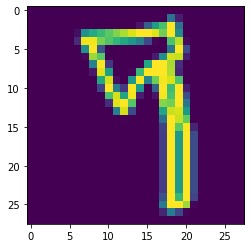

In [7]:
i=1
seed = 11
np.random.seed(seed)
np.random.shuffle(data)
np.random.seed(seed)
np.random.shuffle(label)

t1 = (data)[i]
t = np.reshape(t1,(28,28))
data0 = t
plt.imshow(data0)
print(labels[label[i]],data0.shape)

In [8]:
#split data
training = 0.8
test = 1.-training

x_train = data[0:m.floor(training*len(data))]/ 255.0
y_train = label[0:m.floor(training*len(label))]

x_test = data[m.ceil(training*len(data)):len(data)]/ 255.0
y_test = label[m.ceil(training*len(label)):len(label)]

print(type(x_train),np.shape(x_train))
print(type(y_train),np.shape(y_train))

<class 'numpy.ndarray'> (537308, 28, 28)
<class 'numpy.ndarray'> (537308,)


In [9]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(5),
  tf.keras.layers.Softmax()
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


In [10]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=3)

Epoch 1/5
16791/16791 [==============================] - 40s 2ms/step - loss: 1.0008 - accuracy: 0.9067
Epoch 2/5
16791/16791 [==============================] - 30s 2ms/step - loss: 0.9633 - accuracy: 0.9413
Epoch 3/5
16791/16791 [==============================] - 33s 2ms/step - loss: 0.9594 - accuracy: 0.9451
Epoch 4/5
16791/16791 [==============================] - 32s 2ms/step - loss: 0.9571 - accuracy: 0.9473
Epoch 5/5
16791/16791 [==============================] - 31s 2ms/step - loss: 0.9560 - accuracy: 0.9484


In [11]:
model.evaluate(x_test,  y_test, verbose=2);


4198/4198 - 4s - loss: 0.9528 - accuracy: 0.9516


In [15]:
name = "qd_test2.h5"
saved_model_dir = 'save/'+str(name)
model.save(saved_model_dir)
print("Model Saved to save/qd_test2.h5")

Model Saved to save/qd_test2.h5


In [ ]:
#tf.saved_model.save(model,'save/')
#converter = tf.lite.TFLiteConverter.from_keras_model_file(model)
#Use this if 238 fails 
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/jh/06wb5xgj6vj48hhfwmc8d_rc0000gn/T/tmp0wyva6sv/assets


In [17]:
model.save('save/qd_0')


INFO:tensorflow:Assets written to: save/qd_0/assets


In [20]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
_________________________________________________________________
softmax (Softmax)            (None, 5)                 0         
Total params: 101,125
Trainable params: 101,125
Non-trainable params: 0
_________________________________________________________________


In [22]:
new_model = tf.keras.models.load_model('save/qd_0')
new_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
_________________________________________________________________
softmax (Softmax)            (None, 5)                 0         
Total params: 101,125
Trainable params: 101,125
Non-trainable params: 0
_________________________________________________________________


In [28]:
new_model.evaluate(x_test,  y_test, verbose=2);


4198/4198 - 4s - loss: 0.9522 - accuracy: 0.9523


In [26]:
predictions = new_model.predict(x_test)

airplane


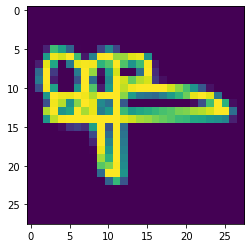

In [27]:
i=2
print(labels[np.argmax(predictions[i])])
plt.figure()
plt.imshow(x_test[i])
plt.show()

(1200, 1200, 4)


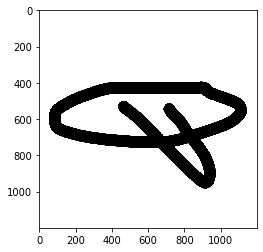

In [29]:
#Show PNG
image = Image.open('dataset/airplane3.png')
# convert image to numpy array
data = asarray(image)
data = abs(data-255.)/255.

# summarize shape
print(data.shape)
plt.imshow(image)
plt.show()



airplane
(1, 28, 28)


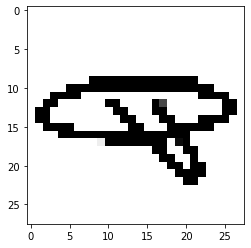

In [30]:
#Convert png to 28x28 array
image = Image.open('dataset/airplane3.png')
image_resize = image.resize((28,28))
data_resize = asarray(image_resize)
data_resize = abs(data_resize-255.)/255.
data_resize = data_resize[:, :, 0]
data_resize = np.expand_dims(data_resize, axis=0)

#Predict png
predictions = new_model.predict(data_resize)
print(labels[np.argmax(predictions)])
print(data_resize.shape)
plt.imshow(image_resize)
plt.show()
